<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Homework_3_shortest_path_Nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
pip install dgl

In [35]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

# Homework 3 - finding shortest path (edge classification)

In [36]:
!wget -O Data_set.zip https://www.dropbox.com/sh/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va?dl=0

--2020-06-30 09:16:24--  https://www.dropbox.com/sh/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va [following]
--2020-06-30 09:16:24--  https://www.dropbox.com/sh/raw/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd8008ca8eac3a73583a9682b08.dl.dropboxusercontent.com/zip_download_get/AeAdubLWqZyME63hU4R75Ao-AjoWVYVKZatct8nu7094oRdmbeB7EYreGaqYPlTLk3mBh3ybIRTtVSIAqLsBBobJ13Z_6dzNDh7ADfdtDlsfvg [following]
--2020-06-30 09:16:25--  https://ucd8008ca8eac3a73583a9682b08.dl.dropboxusercontent.com/zip_download_get/AeAdubLWqZyME63hU4R75Ao-AjoWVYVKZatct8nu7094oRdmbeB7EYreGaqYPlTLk3mBh3ybIRTtVSIAqLsB

In [37]:
!unzip /content/Data_set.zip -d /content/Data_set

Archive:  /content/Data_set.zip
mapname:  conversion of  failed
replace /content/Data_set/test_data.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/Data_set/test_data.zip  
 extracting: /content/Data_set/training_data.zip  


In [38]:
!unzip /content/Data_set/training_data.zip -d /content/training_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/training_data/training_data/graph_3496.json  
  inflating: /content/training_data/training_data/graph_4353.json  
  inflating: /content/training_data/training_data/graph_9561.json  
  inflating: /content/training_data/training_data/graph_6694.json  
  inflating: /content/training_data/training_data/graph_1151.json  
  inflating: /content/training_data/training_data/graph_7986.json  
  inflating: /content/training_data/training_data/graph_4703.json  
  inflating: /content/training_data/training_data/graph_5811.json  
  inflating: /content/training_data/training_data/graph_9131.json  
  inflating: /content/training_data/training_data/graph_1501.json  
  inflating: /content/training_data/training_data/graph_9424.json  
  inflating: /content/training_data/training_data/graph_1014.json  
  inflating: /content/training_data/training_data/graph_3029.json  
  inflating: /content/training_data/training_data/graph_4216.json

In [39]:
!unzip /content/Data_set/test_data.zip -d /content/test_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/test_data/test_data/graph_3443.json  
  inflating: /content/test_data/test_data/graph_7953.json  
  inflating: /content/test_data/test_data/graph_1184.json  
  inflating: /content/test_data/test_data/graph_6641.json  
  inflating: /content/test_data/test_data/graph_774.json  
  inflating: /content/test_data/test_data/graph_3910.json  
  inflating: /content/test_data/test_data/graph_2602.json  
  inflating: /content/test_data/test_data/graph_7400.json  
  inflating: /content/test_data/test_data/graph_2252.json  
  inflating: /content/test_data/test_data/graph_5597.json  
  inflating: /content/test_data/test_data/graph_324.json  
  inflating: /content/test_data/test_data/graph_1887.json  
  inflating: /content/test_data/test_data/graph_7050.json  
  inflating: /content/test_data/test_data/graph_5578.json  
  inflating: /content/test_data/test_data/graph_7545.json  
  inflating: /content/test_data/test_data/graph_385

### The data here is stored in 10,000 json files for each of the training/testing datasets

In [40]:
path_to_ds = '/content/training_data/training_data/'
path_to_test_ds = '/content/test_data/test_data/'

### the custom dataset object will load the json files, and then convert the graphs to DGL graphs

In [41]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].edata['on_path']

### The node features are just 2 numbers - [0,0] for most nodes,
### and [1,0] for the start node, [0,1] for the end node
### the edges all have a property of "distance" which is essentially random
### and a label if they are on the shortest path or not

In [42]:
train_ds = CustomDataset(path_to_ds)
test_ds = CustomDataset(path_to_test_ds)

In [43]:
train_ds[90][0]

DGLGraph(num_nodes=16, num_edges=64,
         ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32)}
         edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.int64)})

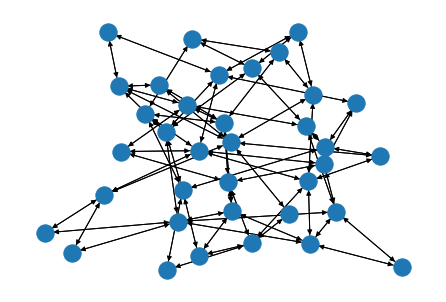

In [44]:
nx.draw( dgl.to_networkx(train_ds[80][0]) )

In [45]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [46]:
collate(train_ds)[1].shape

torch.Size([1316072, 1])

In [47]:
edge_hidden1 = 12

In [49]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        in_features = 2*(2+40)+1 
        # 40 hidden nodes + 1 source + 1 destination , multiplied by two as each node has two features 
        self.layer1 = nn.Sequential(nn.Linear(in_features,edge_hidden1-2),nn.ReLU(),nn.Linear(edge_hidden1-2,edge_hidden1),nn.ReLU())

    def forward(self, x):
      print("dst: ", x.dst['node_features'].shape)
      print("dst_h: ", x.dst['node_hidden_state'].shape)
      print("src: ", x.src['node_features'].shape)
      print("src_h: ", x.src['node_hidden_state'].shape)
      print("distance: ", torch.unsqueeze(x.data['distance'],1).shape)  
      x_concat = torch.cat((x.dst['node_features'],x.dst['node_hidden_state'], x.src['node_features'], x.src['node_hidden_state'],torch.unsqueeze(x.data['distance'],1)), 1)
      print("concat: ", x.data['distance'].shape)
      output = self.layer1(x_concat)
      return {'edge hidden represetation': output }
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
        
        

class EdgeClassifier(nn.Module):
    def __init__(self):
        super(EdgeClassifier, self).__init__()
        in_features = 2*(2+40)+1 
        # 40 hidden nodes + 1 source + 1 destination , multiplied by two as each node has two features 
        self.layer1 = nn.Sequential(nn.Linear(in_features,20),nn.ReLU(),nn.Linear(20,1))

    def forward(self, x):
      #print("dst: ", x.dst['node_features'].shape)
      #print("dst_h: ", x.dst['node_hidden_state'].shape)
      #print("src: ", x.src['node_features'].shape)
      #print("src_h: ", x.src['node_hidden_state'].shape)
      #print("distance: ", torch.unsqueeze(x.data['distance'],1).shape)     
      x_concat = torch.cat((x.dst['node_features'],x.dst['node_hidden_state'], x.src['node_features'], x.src['node_hidden_state'],torch.unsqueeze(x.data['distance'],1)), 1)
      output = self.layer1(x_concat)
      return {'edge_class_prediction': output }
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
        
        
    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
        in_features = 2+edge_hidden1+40
        self.layer1 = nn.Sequential(
            nn.Linear(in_features,40),nn.ReLU()
        )
        
    def forward(self, x):
      x_concat = torch.cat((x.mailbox['edge hidden represetation'].sum(1),x.data['node_features'],x.data['node_hidden_state']), 1)
      out = self.layer1(x_concat)
      return {'node_hidden_state': out }
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        # return a new hidden state for the node
        


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        self.node_init = nn.Sequential(nn.Linear(2,40))
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.edge_classifier = EdgeClassifier()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        iterations = 10 
        for i in range(iterations):
            #print("iteraion_is%i"%i)
            #print(g.ndata['node_hidden_state'].shape)
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the edges - so finally apply your edge classifier -
        g.apply_edges(self.edge_classifier)
        
        #and extract its output 
        out = g.edata['edge_class_prediction']

        
        return out 

In [50]:
net = Classifier()

In [51]:
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [52]:
net = net.to(torch.device('cuda'))

In [53]:
loss_func = nn.BCEWithLogitsLoss()

In [54]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

In [55]:
import time
import copy
n_epochs = 25
loss_vs_epoch = []
accuracy_vs_epoch = []
for epoch in tqdm(range(n_epochs)):
  
    since = time.time()
    val_loss_history = []
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 10000.0
    best_loss_TP = 0
    best_loss_TN = 0
    best_loss_FP = 0
    best_loss_FN = 0

    net.train()
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0
    training_loss = 0
    for x,y in data_loader:
        
        x = x.to(torch.device('cuda'))
        y = y.cuda()
        optimizer.zero_grad()
        predicted = net(x)
        loss = loss_func(predicted,y)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        
        y = y.cpu().data.numpy()
        #print(y)
        predicted_values = nn.Sigmoid()(predicted.cpu()).data.numpy()
        predicted_values[predicted_values >= 0.5] = 1
        predicted_values[predicted_values <0.5] = 0
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        true_positive+= len(np.where( (predicted_values==y) & (y==1) )[0])
        true_negative+= len(np.where( (predicted_values==y) & (y==0) )[0])
        false_positive+= len(np.where( (predicted_values!=y) & (y==0) )[0])
        false_negative+= len(np.where( (predicted_values!=y) & (y==1) )[0])
    
    TP = true_positive/total_positives
    FN = false_negative/total_positives
    TN = true_negative/total_negatives
    FP = false_positive/total_negatives

    net.eval()
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0
    validation_loss = 0
    for x,y in test_data_loader:
        
        x = x.to(torch.device('cuda'))
        y = y.cuda()
        predicted = net(x)
        loss = loss_func(predicted,y)
        validation_loss += loss.item()
        
        y = y.cpu().data.numpy()
        predicted_values = nn.Sigmoid()(predicted.cpu()).data.numpy()
        predicted_values[predicted_values >= 0.5] = 1
        predicted_values[predicted_values <0.5] = 0
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        true_positive+= len(np.where( (predicted_values==y) & (y==1) )[0])
        true_negative+= len(np.where( (predicted_values==y) & (y==0) )[0])
        false_positive+= len(np.where( (predicted_values!=y) & (y==0) )[0])
        false_negative+= len(np.where( (predicted_values!=y) & (y==1) )[0])

    TP = true_positive/total_positives
    FN = false_negative/total_positives
    TN = true_negative/total_negatives
    FP = false_positive/total_negatives
    
    if validation_loss < best_loss:
      best_loss = validation_loss
      best_model_wts = copy.deepcopy(net.state_dict())
      val_loss_history.append(validation_loss)
      best_loss_TP = TP
      best_loss_TN = TN
      best_loss_FP = FP
      best_loss_FN = FN

loss_vs_epoch.append([training_loss, validation_loss])

dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size([4100, 40])
distance:  torch.Size([4100, 1])
concat:  torch.Size([4100])
dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size([4100, 40])
distance:  torch.Size([4100, 1])
concat:  torch.Size([4100])
dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size([4100, 40])
distance:  torch.Size([4100, 1])
concat:  torch.Size([4100])
dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size([4100, 40])
distance:  torch.Size([4100, 1])
concat:  torch.Size([4100])
dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size([4100, 40])
distance:  torch.Size([4100, 1])
concat:  torch.Size([4100])
dst:  torch.Size([4100, 2])
dst_h:  torch.Size([4100, 40])
src:  torch.Size([4100, 2])
src_h:  torch.Size

KeyboardInterrupt: ignored

In [ ]:
plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

In [ ]:
from scipy.special import expit, logit

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')

net.eval()
net.cpu()

dgl_g = test_ds[5578][0]

output_pred = net(dgl_g).data.numpy()

nx_graph = dgl.to_networkx(dgl_g)
pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()

### Once you train your network - 
### you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,
### most of the edges in the dataset have a label 0, so its quite easy to reach a high true negative rate
### but train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [ ]:
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print(true_positive/total_positives)
print(false_negative/total_positives)
print(true_negative/total_negatives)
print(false_positive/total_negatives)